**Chi²-Test: Unfälle in Bar-Nähe häufiger abends/nachts?**

- H0: Tageszeit und Bar-Nähe sind unabhängig
- H1: In Bar-Nähe passieren überproportional viele Unfälle abends/nachts
- Schwelle: 150m Entfernung zur nächsten Bar

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_parquet("unfaelle_mit_strassen.parquet")
print(f"{len(df)} Unfälle, Zeitkategorien: {df['ZeitKategorie'].value_counts().to_dict()}")

12488 Unfälle, Zeitkategorien: {'Tag': 5376, 'Abend': 3001, 'Morgen': 2765, 'Spätabend': 765, 'Nacht': 581}


### Daten vorbereiten
- Bar-Nähe: ≤150m vs >150m zur nächsten Bar
- Zeit: Abend/Nacht (18-5 Uhr) vs Morgen/Tag (5-18 Uhr)

In [5]:
df = df.dropna(subset=['dist_bar', 'ZeitKategorie'])

df['Bar_Naehe'] = np.where(df['dist_bar'] <= 150, "Bar-Nähe (<150 m)", "Keine Bar-Nähe (>150 m)")
df['Zeit_Bin'] = df['ZeitKategorie'].map({'Abend': 1, 'Nacht': 1, 'Spätabend': 1, 'Morgen': 0, 'Tag': 0}).astype(int)

# Kontingenztafel
table = pd.crosstab(df['Zeit_Bin'], df['Bar_Naehe'])
table = table[["Bar-Nähe (<150 m)", "Keine Bar-Nähe (>150 m)"]]
print(table)

Bar_Naehe  Bar-Nähe (<150 m)  Keine Bar-Nähe (>150 m)
Zeit_Bin                                             
0                       1983                     6158
1                       1340                     3007


### Chi²-Test und Visualisierung
- Beobachtete vs erwartete Häufigkeiten
- Residuen zeigen wo die Abweichung am stärksten ist

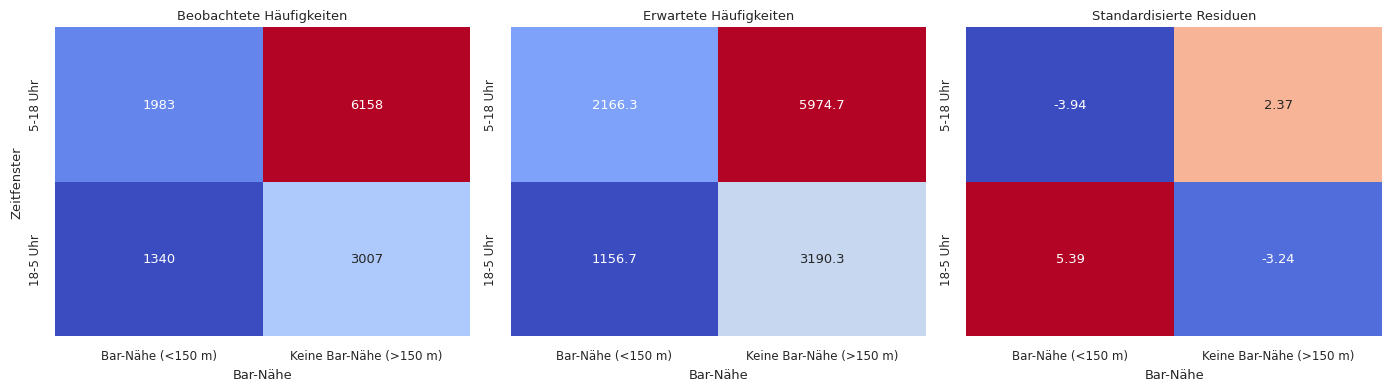

n = 12488
Chi² = 60.37, df = 1, p = 0.00000


In [6]:
observed = table.values
chi2, p, dof, expected = stats.chi2_contingency(table)
residuals = (observed - expected) / np.sqrt(expected)  # standardisierte Residuen

yticks = ["5-18 Uhr", "18-5 Uhr"]
sns.set_theme(style="white", font_scale=0.78)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Beobachtete Häufigkeiten
sns.heatmap(observed, annot=True, fmt=".0f", cmap="coolwarm", cbar=False,
            xticklabels=table.columns, yticklabels=yticks, ax=axes[0])
axes[0].set_title("Beobachtete Häufigkeiten")
axes[0].set_xlabel("Bar-Nähe")
axes[0].set_ylabel("Zeitfenster")

# Erwartete Häufigkeiten (falls unabhängig)
sns.heatmap(expected, annot=True, fmt=".1f", cmap="coolwarm", cbar=False,
            xticklabels=table.columns, yticklabels=yticks, ax=axes[1])
axes[1].set_title("Erwartete Häufigkeiten")
axes[1].set_xlabel("Bar-Nähe")

# Residuen: positiv = mehr als erwartet
sns.heatmap(residuals, annot=True, fmt=".2f", cmap="coolwarm", cbar=False,
            xticklabels=table.columns, yticklabels=yticks, ax=axes[2])
axes[2].set_title("Standardisierte Residuen")
axes[2].set_xlabel("Bar-Nähe")

plt.tight_layout()
plt.show()

print(f"n = {observed.sum()}")
print(f"Chi² = {chi2:.2f}, df = {dof}, p = {p:.5f}")

Chi² = 81.53, p < 0.00001 -> H0 wird klar verworfen. In Bar-Nähe ist der Anteil der Abend/Nacht-Unfälle signifikant höher als erwartet (Residuum +7.5).